<a href="https://colab.research.google.com/github/ReAlex1902/Pneumonia_Detection/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run next scripts in colab to download data

In [1]:
!pip install kaggle

In [2]:
## upload your kaggle.json

from google.colab import files
files.upload()

{}

In [3]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Downloading dataset:
from zipfile import ZipFile
import os
import pandas as pd

# # The below code is ran in google colab
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"  # username from the json file
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"  # key from the json file
# !kaggle datasets download -d praveengovi/coronahack-chest-xraydataset  # api copied from kaggle

# Create a ZipFile Object and load chest-xray-pneumonia.zip in it
with ZipFile("/content/coronahack-chest-xraydataset.zip", "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

# KAGGLE LINK: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

# Import necessary libs

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import models, transforms
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Implementing code to get data

In [7]:
DATA_INFO_PATH = os.path.join('Chest_xray_Corona_Metadata.csv')
TRAIN_FOLDER = os.path.join('Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')    
TEST_FOLDER = os.path.join('Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')

In [8]:
data = pd.read_csv(DATA_INFO_PATH, index_col = 0)

In [9]:
data.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


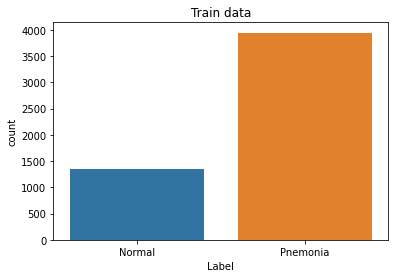

In [10]:
sns.countplot(data = data[data['Dataset_type'] == 'TRAIN'], x = 'Label');
plt.title("Train data");

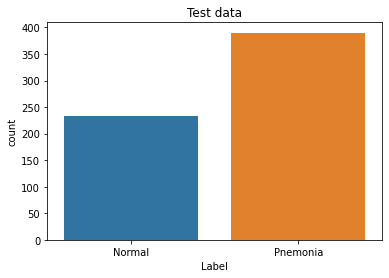

In [11]:
sns.countplot(data = data[data['Dataset_type'] == 'TEST'], x = 'Label');
plt.title("Test data");

## Dataset class

person1442_bacteria_3726.jpeg
2467    Pnemonia
Name: Label, dtype: object

person97_virus_180.jpeg
5053    Pnemonia
Name: Label, dtype: object

person1209_bacteria_3161.jpeg
1755    Pnemonia
Name: Label, dtype: object

NORMAL2-IM-0474-0001.jpeg
658    Normal
Name: Label, dtype: object

IM-0359-0001.jpeg
155    Normal
Name: Label, dtype: object



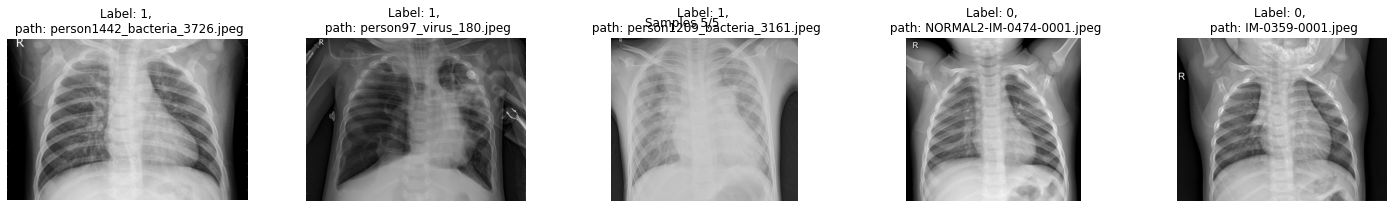

In [12]:
class Pneumonia_Dataset(Dataset):
    def __init__(self, csv_file, folder, transform = None):
        """
        csv_file (string) - scv file with metadata
        folder (string) - folder with images
        transform (callable, optional) - transform applied to the images, augmentation
        """
        self.csv_file = pd.read_csv(csv_file)
        self.folder = folder
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):
        image_name = os.listdir(self.folder)[index]
        image_path = os.path.join(self.folder, image_name)
        image = Image.open(image_path)
        image = image.convert('RGB')

        ## We get the picture from folder by index, take its name and get the label from csv by name
        y = 1 if self.csv_file[self.csv_file['X_ray_image_name'] == image_name]['Label'].to_string().split()[1] == 'Pnemonia' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, y, image_path
    
def visualize_samples(dataset, indices, title = None, count = 5):
    # visualize random samples
    plt.figure(figsize=(count*5,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, path = dataset[index]
        path = os.path.split(path)[-1]
        print(path)
        print(data[data['X_ray_image_name'] == path]['Label'])
        print()
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.title(f"Label: {y}, \n path: {path}")
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')       

orig_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER)
indices = np.random.choice(np.arange(len(orig_dataset)), 5, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

person1442_bacteria_3726.jpeg
2467    Pnemonia
Name: Label, dtype: object

person97_virus_180.jpeg
5053    Pnemonia
Name: Label, dtype: object

person1209_bacteria_3161.jpeg
1755    Pnemonia
Name: Label, dtype: object

NORMAL2-IM-0474-0001.jpeg
658    Normal
Name: Label, dtype: object

IM-0359-0001.jpeg
155    Normal
Name: Label, dtype: object



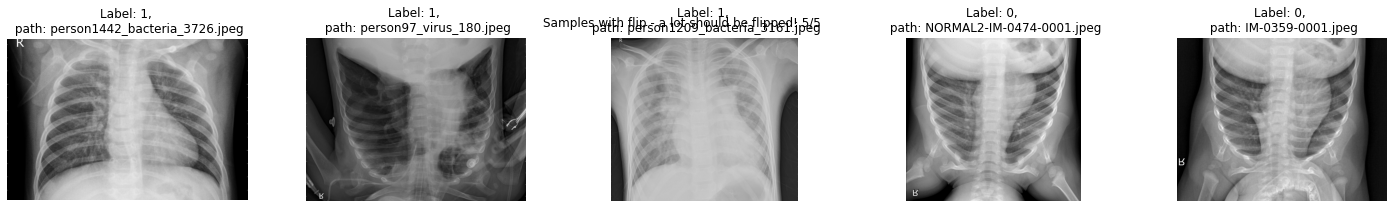

In [13]:
# Let's make sure transforms work!
dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, transform=transforms.RandomVerticalFlip(0.9))
visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

## Creating our dataset for training and testing

In [14]:
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    # Use mean and std for pretrained models
                    # https://pytorch.org/docs/stable/torchvision/models.html
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])                         
            ])

train_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, transform = transform)

test_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TEST_FOLDER, transform = transform)

In [15]:
len(train_dataset), len(test_dataset)

(5309, 624)

## Go to training

In [16]:
batch_size = 16

data_size = len(train_dataset)
validation_fraction = 0.3

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(11)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [17]:
## Let's use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y, _) in enumerate(train_loader):
                
            optimizer.zero_grad()
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        if scheduler:
            scheduler.step()
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    right = 0
    total = 0
    for batch in loader:
        x, y, _ = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        preds = model(x_gpu)
        preds = torch.argmax(preds, axis = 1)
        right += torch.sum(preds == y_gpu)
        total += y_gpu.shape[0]
    return float(right) / total

In [19]:
torch.cuda.empty_cache() ## clear cache before training

In [20]:
import torch.nn as nn
import torch.optim as optim

model = models.densenet201(pretrained = True)
# for param in model.parameters():        ## freezing
#     param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 2)

model.to(device)
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# parameters = model.fc.parameters()
parameters = model.parameters()

EPOCHS = 12

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr = 0.00008)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, EPOCHS, scheduler)

Average loss: 0.133568, Train accuracy: 0.952345, Val accuracy: 0.976078
Average loss: 0.085732, Train accuracy: 0.966849, Val accuracy: 0.980034
Average loss: 0.073543, Train accuracy: 0.975513, Val accuracy: 0.983801
Average loss: 0.061177, Train accuracy: 0.977962, Val accuracy: 0.987568
Average loss: 0.057604, Train accuracy: 0.978527, Val accuracy: 0.989075
Average loss: 0.053576, Train accuracy: 0.979846, Val accuracy: 0.988510
Average loss: 0.046132, Train accuracy: 0.983989, Val accuracy: 0.989640
Average loss: 0.040860, Train accuracy: 0.984366, Val accuracy: 0.988510
Average loss: 0.031338, Train accuracy: 0.987192, Val accuracy: 0.989829
Average loss: 0.038021, Train accuracy: 0.985308, Val accuracy: 0.993596
Average loss: 0.030533, Train accuracy: 0.990017, Val accuracy: 0.994914
Average loss: 0.033519, Train accuracy: 0.986438, Val accuracy: 0.982859


In [39]:
# model - densenet201 (pretrained = True)
# lr = 0.00007
# T_max = 10
# all parameters on

# accuracy = 0.838
# F1 = 0.89
# precision = 0.997
# recall = 0.804

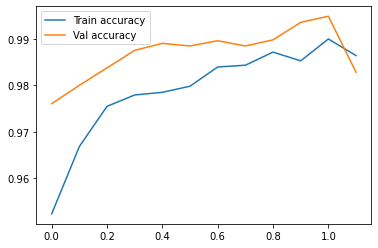

In [21]:
sns.lineplot(x = [i*0.1 for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
sns.lineplot(x = [i*0.1 for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');

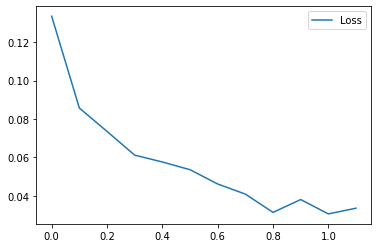

In [22]:
sns.lineplot(x = [i*0.1 for i in range(EPOCHS)], y = loss_history, label = 'Loss');

In [23]:
# compute_accuracy(model, test_loader)

In [27]:
import sklearn.metrics as metrics

def evaluate_model(model, dataset):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, batch_size = 1)
    ground_truth = []
    predictions = []

    for batch in loader:
        x, y, _ = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        ground_truth.append(int(y_gpu))
        prediction = model(x_gpu)
        _, prediction = torch.max(prediction, axis = 1)    ## torch.max() returns (values, indices)
        predictions.append(int(prediction))
    
    return predictions, ground_truth

def binary_classification_metrics(prediction, ground_truth):
    precision = metrics.precision_score(prediction, ground_truth)
    recall = metrics.recall_score(prediction, ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = compute_accuracy(model, test_loader)
    return precision, recall, f1, acc

predictions, ground_truth = evaluate_model(model, test_dataset)
precision, recall, f1, accuracy = binary_classification_metrics(predictions, ground_truth)
# print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall, accuracy))
print(f'F1: {f1}, P: {precision}, R: {recall}, Acc: {accuracy}')

F1: 0.9080188679245282, P: 0.9871794871794872, R: 0.8406113537117904, Acc: 0.8701923076923077
